# Import Libraries Required


In [1]:
import numpy as np
import pandas as pd 
from subprocess import check_output
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import math
from skimage import io
import itertools
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import ClassifierChain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score

import warnings
warnings.filterwarnings('ignore')

## Data Import and preprocess

In [2]:
# Import labels
csv_tl = pd.read_csv('train_labels.csv')

# Land Tags - we can have multiple combination of these
def land_tags(landTags):
    land_list=[]
    other_tags=['habitation','bare_ground','cultivation','agriculture','blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    if 'primary' in landTags:
        land_list.append('primary')
    if 'water' in landTags:
        land_list.append("water")
    other_present=0
    for i in other_tags:
        if i in landTags:
            other_present=1
            break
    if other_present==1:
        land_list.append('other')
    if land_list == []:
        land_list.append('none')
    return ' '.join(land_list)
    
# Weather tags - we can only have 1 of these.
def weather_tags(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'

# Map the tags we created to respective labels.
csv_tl['weather'] =csv_tl.tags.map(weather_tags)
csv_tl['land'] = csv_tl.tags.map(land_tags)
csv_tl['combined'] = csv_tl[['weather', 'land']].apply(lambda x: ' '.join(x), axis=1)

# Save the results to a csv called train_labels_clean.csv
csv_tl.to_csv("train_labels_clean.csv")

# Haze Removal Using Dark Channel Prior

In [3]:
# Taken From:
# Kaiming He, Jian Sun, and Xiaoou Tang 
# Single Image Haze Removal Using Dark Channel Prior
# IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 33, no. 12, 2341--2353 (2010)
# DOI:  10.1109/TPAMI.2010.168

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


def remove_haze(image):
    src = cv2.imread(image);
    I = src.astype('float64')/255;
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);
    return J

# Read JPG and TIF Images for Image Color Intensity Data

In [4]:
# Path of images
train_path_jpg='/home/sgzlytdc/raw_data/train-jpg/'
train_path_tif='/home/sgzlytdc/raw_data/train-tif-v2/'

# Read JPG Trained Images
def read_train_jpgs():
    #retrieve jpg data - compress from 256x256 to 64x64 for faster training [remove constraint in final product]
    input_jpgs=np.zeros((csv_tl.shape[0],64,64,11))
    index = 0
    while index < csv_tl.shape[0]:
        image_name = "train_"+str(index)+".jpg"
        ##read the image
        read_img = plt.imread(train_path_jpg+image_name)
        read_img=read_img[:,:,:3]
        ##reduce the image size for smaller processing
        jpg_img=transform.resize(read_img, (64,64,3))
        ##use the remove haze image to better identify features
        haze_img=remove_haze(train_path_jpg+image_name)
        haze_img=transform.resize(haze_img, (64,64,3))
        ##create a matrix for both features
        clean_img=np.zeros((64,64,6))
        clean_img[:,:,:3]=jpg_img
        clean_img[:,:,3:6]=haze_img
        input_jpgs[index,:,:,0:6] = clean_img
        index = index + 1
    return input_jpgs
        
# Add greyscale to jpg data
def add_tow_greyscale_information(input_jpgs):
    input_jpgs[:,:,:,6]=input_jpgs[:,:,:,0]*0.2989+input_jpgs[:,:,:,1]*0.5870+input_jpgs[:,:,:,2]*0.1140
    input_jpgs[:,:,:,7]=input_jpgs[:,:,:,3]*0.2989+input_jpgs[:,:,:,4]*0.5870+input_jpgs[:,:,:,5]*0.1140
    return input_jpgs

# Read TIF data
def read_train_tifs(input_data):
    tif_data=np.zeros((input_data.shape[0],64,64,4))
    i = 0
    while i<input_data.shape[0]:
        img = io.imread(train_path_tif+"train_"+str(i)+".tif")
        small_img=transform.resize(img, (64,64,4))
        tif_data[i,:,:,:] = small_img
        i = i+1
    return tif_data
        
# Get the features from the images in jpg and tif
def get_total_features(input_jpgs, tif_data):
    
    # the best infrared threshold value to filt out water is 0.09 according to 
    best_water_infrared = 0.09
    min_water_infrared = 0.03
    
    for i, j in enumerate(tif_data):
        mean_infrared = tif_data[i,:,:,3].mean()
        if mean_infrared < best_water_infrared and mean_infrared > min_water_infrared:
            input_jpgs[:,:,:,8] = 1.0
        else:
            input_jpgs[:,:,:,8] = 0.0
    
  
    #This take the infrared pixels, subtracts the red, and divides by the total to indicate vegetation
    input_jpgs[:,:,:,9]=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 
    
    #This take the infrared pixels, subtracts the green, and divides by the total just in case 
    # green and infrared have an interesting relationship
    #data_jpgs[:,:,:,10]=(tif_data[:,:,:,3]-tif_data[:,:,:,1])/(tif_data[:,:,:,3]+tif_data[:,:,:,1]) 
    return input_jpgs

# Get various stats in a single jpg image.
def get_jpg_stats(i,input_jpgs,jpg_input_stats,stats_values):
        jpg_input_stats[i,:11]=np.average(stats_values[i,:,],axis=0)
        jpg_input_stats[i,11:22]=np.var(stats_values[i,:,],axis=0)
        jpg_input_stats[i,22:33]=np.std(stats_values[i,:,],axis=0)
        kurt_skew=np.zeros((22,))
        j=0
        while j<6:
            kurt_skew[j]=scipy.stats.kurtosis(input_jpgs[i,:,:,j].ravel())
            kurt_skew[j+11]=scipy.stats.skew(input_jpgs[i,:,:,j].ravel())
            j = j+1
        jpg_input_stats[i,33:55]=kurt_skew    

        # Get histogram from haze removed jpg.
        j=0
        while j<3:
            start=55+j*20
            end=start+20
            t=np.array(np.histogram(input_jpgs[i,:,:,j+3],bins=20, range=(0,1))[0])
            jpg_input_stats[i,start:end]=t
            j = j+1
            

        # Get histogram from IR jpg.
        j=0
        while j<3:
            start=105+j*20
            end=start+20
            t=np.array(np.histogram(input_jpgs[i,:,:,j+8],bins=20, range=(-1,1))[0])
            jpg_input_stats[i,start:end]=t
            j=j+1
        return  jpg_input_stats
    
# Function to get ALL jpg stats.
def get_all_jpg_stats(csv_input, input_jpgs):
    stats_values=np.reshape(input_jpgs,(input_jpgs.shape[0],4096,11))    
    jpg_input_stats=np.zeros((csv_input.shape[0],175))
    for index in range(stats_values.shape[0]):
        get_jpg_stats(index,input_jpgs,jpg_input_stats,stats_values)

    return jpg_input_stats

# Function to help get all edge statistics using laplacian and sobel algorithms.
def get_all_edge_stats(csv_input, input_jpgs):
    # Edge data
    edge_stats=np.zeros((csv_input.shape[0],12))
    i=0
    while i<csv_input.shape[0]:
        img=input_jpgs[i,:,:,3:6]
        hazy_img=input_jpgs[i,:,:,0:3]
        # With haze
        edge_stats[i,0]=cv2.Laplacian(img, cv2.CV_64F).mean()
        edge_stats[i,1]=cv2.Laplacian(img, cv2.CV_64F).var()
        edge_stats[i,2]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).var()
        edge_stats[i,3]=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).mean()
        edge_stats[i,4]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).mean()
        edge_stats[i,5]=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).var()
        # Without haze
        edge_stats[i,6]=cv2.Laplacian(hazy_img, cv2.CV_64F).mean()
        edge_stats[i,7]=cv2.Laplacian(hazy_img, cv2.CV_64F).var()
        edge_stats[i,8]=cv2.Sobel(hazy_img,cv2.CV_64F,1,0,ksize=5).var()
        edge_stats[i,9]=cv2.Sobel(hazy_img,cv2.CV_64F,1,0,ksize=5).mean()
        edge_stats[i,10]=cv2.Sobel(hazy_img,cv2.CV_64F,0,1,ksize=5).mean()
        edge_stats[i,11]=cv2.Sobel(hazy_img,cv2.CV_64F,0,1,ksize=5).var()
        i=i+1
    # Return the image edge.
    return edge_stats

# Gets the frame from jpg stats.
def get_frame_from_jpg(jpg_stats):
    colours=['red','green','blue','red_dehaze','green_dehaze','blue_dehaze','gray','gray_dehaze','water_index','veg_index','other_irr']
    #colours=['red','green','blue','red_dehaze','green_dehaze','blue_dehaze','gray','gray_dehaze','water_index','veg_index']
    operations=['mean','variance','std','kurtosis','skew']
    header_list=[]
    i=0
    while i<len(operations):
        j=0
        while j<len(colours):
            string=colours[j]+'_'+operations[i]
            header_list.append(string)
            j=j+1
        i=i+1 
    i=0
    while i<3:
        j=0
        while j<20:
            string=colours[j]+"_hist_bucket_"+str(i)
            header_list.append(string)
            j=j+1
        i=i+1 
        
    i=0
    while i<3:
        j=0
        while j<20:
            string=colours[j+8]+"_hist_bucket_"+str(i)
            header_list.append(string)
            j=j+1
        i=i+1         

    frame = pd.DataFrame(jpg_stats[:,:175], columns=header_list)
    return frame

# Gets the frame from edge stats.
def get_frame_from_edge(edge_stats):
    column_heads=['laplac_mean','laplac_var','sob_mean1','sob_var1','sob_mean2','sob_var2',
                  'laplac_mean_hazy','laplac_var_hazy','sob_mean1_hazy','sob_hazy_var','sob_hazymean_2','sob_hazy_var2']
    frame = pd.DataFrame(edge_stats, columns=column_heads)
    return frame

# Combine frames together to concatenate into 1 single data frame.
def combine_two_frame(frame1, frame2):
    all_information=pd.concat([frame1, frame2], axis=1)
    return all_information

# Update input_jpgs array
# For JPG
input_jpgs = read_train_jpgs()
input_jpgs = add_tow_greyscale_information(input_jpgs)
# For TIF
tif_data = read_train_tifs(csv_tl)
input_jpgs = get_total_features(input_jpgs, tif_data)

# Get Stats from input_jpgs
jpg_stats = get_all_jpg_stats(csv_tl, input_jpgs)
edge_stats = get_all_edge_stats(csv_tl, input_jpgs)

# Get the frame from both stats, and combine them into 1 dataframe.
frame1 = get_frame_from_jpg(jpg_stats)
frame2 = get_frame_from_edge(edge_stats)
dataframe = combine_two_frame(frame1, frame1)

# Save the dataframe into a csv file for later analysis.
dataframe.to_csv('train_data.csv')


## Plotting some figures

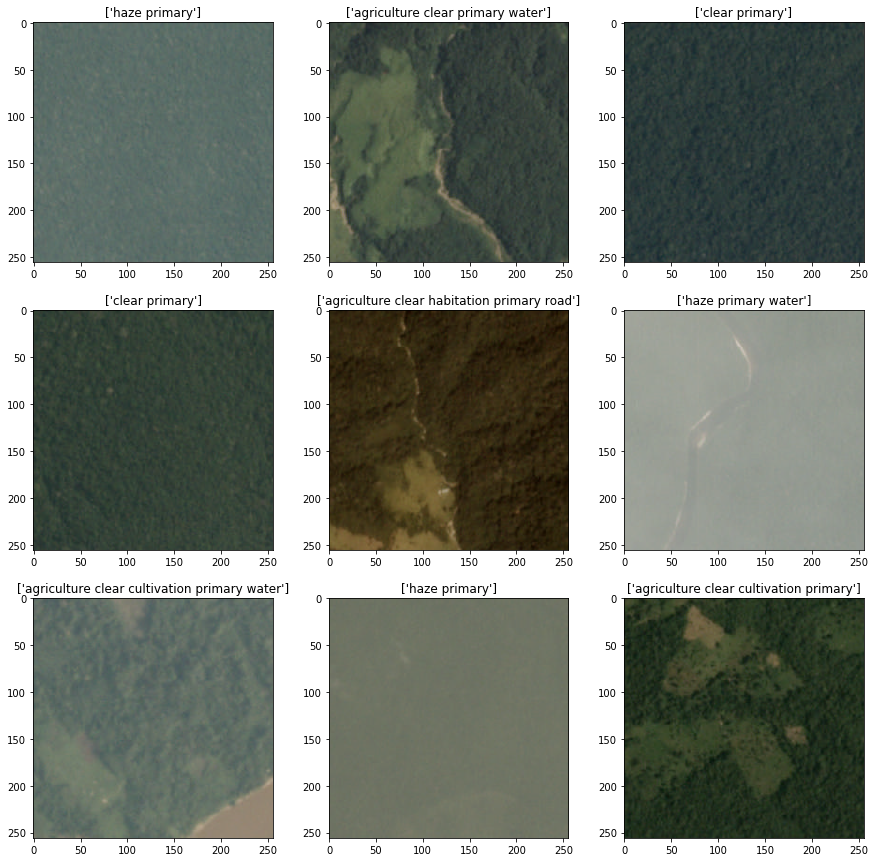

In [5]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(train_path_jpg+"train_"+str(i)+".jpg"))
    plt.title(str(csv_tl[csv_tl.image_name == 'train_'+str(i)].tags.values))

## Removing Haze from Image 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "Haze Removed: ['agriculture clear cultivation primary']")

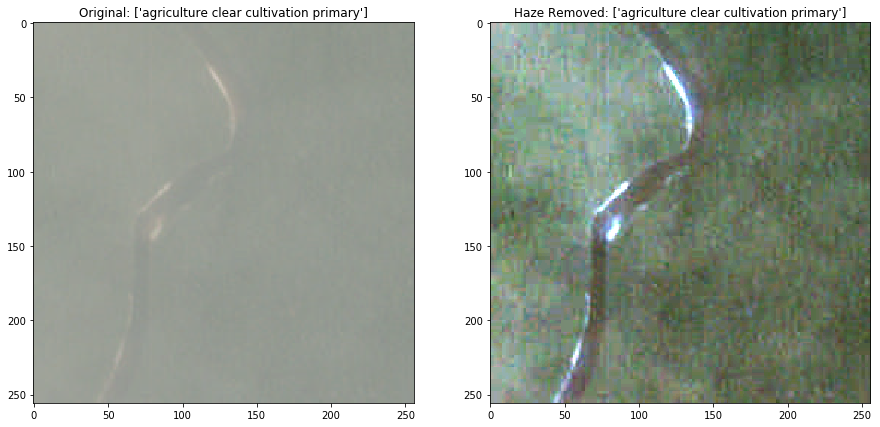

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(plt.imread(train_path_jpg+"train_5.jpg"))
plt.title("Original: "+str(csv_tl[csv_tl.image_name == 'train_'+str(i)].tags.values))
haze_img=remove_haze(train_path_jpg+"train_5.jpg")
plt.subplot(1,2,2)
plt.imshow(haze_img)
plt.title("Haze Removed: " +str(csv_tl[csv_tl.image_name == 'train_'+str(i)].tags.values))

# Create output of Image Processing, and use a heatmap for EDA.

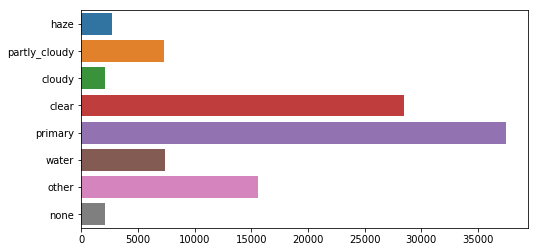

In [7]:
# Display counts of weather and land labels
csv_tl["combined_tags"] = csv_tl["weather"] + " " + csv_tl["land"]
labels = csv_tl['combined_tags'].apply(lambda x: x.split(' '))
all_tags = [item for sublist in list(labels.values) for item in sublist]
labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=labels_s, y=labels_s.index, orient='h', order = ['haze', 'partly_cloudy', 'cloudy', 'clear','primary', 'water', 'other', 'none'])

# Display correlation between labels 
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=1000, width=1000, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

# Load data and labels from file

In [8]:
# Get the processed train labels.
train_clean_labels = pd.read_csv('train_labels_clean.csv')
# Get the processed train data.
train_data = pd.read_csv('train_data.csv')
#Use min max to help scale / transform data.
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(train_data)

# Create training and test sets for weather, land, and multi-label land labels by randomly splitting the original dataset as 90%/10%
train_weather_data, test_weather_data, train_weather_labels, test_weather_labels = train_test_split(data_minmax, train_clean_labels.weather, test_size=0.1)
train_land_data, test_land_data, train_land_labels, test_land_labels = train_test_split(data_minmax, train_clean_labels.land, test_size=0.1)
train_clean_labels['tags_split'] = train_clean_labels['land'].map(lambda row: row.split(" "))
train_clean_labels['combined_split'] = train_clean_labels['combined'].map(lambda row: row.split(" "))

# Use MultiLabelBinarizer for analysis on label data
mlb = MultiLabelBinarizer()
multi_labels_land = mlb.fit_transform(train_clean_labels['tags_split'])
multi_labels_combined = mlb.fit_transform(train_clean_labels['combined_split'])
train_land_data_multi, test_land_data_multi, train_land_labels_multi, test_land_labels_multi= train_test_split(data_minmax, multi_labels_land, test_size=0.1)
train_data_combined, test_data_combined, train_labels_combined, test_labels_combined= train_test_split(data_minmax, multi_labels_combined, test_size=0.1)

# Helper Method to grab Output Result - Confusion Matrix and Accuracy Readings

In [9]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def single_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)
    
    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 
    
    print(classification_report(test_label,model_predictions))

#     con_fu=confusion_matrix(test_label, model_predictions)
#     class_list=sorted(list(set(test_label)))
#     return plot_confusion_matrix(con_fu, classes=class_list)

def multiple_model_output(pipeline, scores, train_data, train_label, test_data, test_label):
    pipeline.fit(train_data,train_label)
    model_predictions=pipeline.predict(test_data)
    
    print("Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    print(classification_report(test_label,model_predictions))
    
    return "Cross-Validation\n Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

def multi_gridsearchcv(param_grid, model, train_data, train_labels, test_data):
    model_tuning=GridSearchCV(model, param_grid)
    model_tuning.fit(train_data, train_labels)
    print("The best parameters for the model are : " +str(model_tuning.best_params_))
    
    
def multi_pipeline(model, estimator, train_data, train_labels, test_data, test_labels, scoring='f1_micro', cv=10):
    multi_pipe = Pipeline([
        (estimator,model),
    ])
    multi_scores = cross_val_score(multi_pipe, 
                                 train_data,
                                 train_labels,
                                 scoring=scoring,
                                 cv=cv
                                )
    
    multiple_model_output(multi_pipe, multi_scores, train_data, train_labels, test_data, test_labels)

# Decision Tree for Weather Prediction

In [10]:
# Use GridSearchCV to find the best depth for decision tree
param_grid = dict(DecisionTrees__max_depth=[5,10,20,50,100], DecisionTrees__min_samples_leaf=[2,5,10,15,20,25])
DT_model=DecisionTreeClassifier()
DT_pipeline = Pipeline([
    ('DecisionTrees', DT_model),
])

grid_tree = GridSearchCV(DT_pipeline, param_grid)
grid_tree.fit(train_weather_data, train_weather_labels)
tree_preds = grid_tree.predict(test_weather_data)
print("The best tree parameters are: " + str(grid_tree.best_params_))

The best tree parameters are: {'DecisionTrees__min_samples_leaf': 20, 'DecisionTrees__max_depth': 10}


In [32]:
# Train and run Decision Tree with weather label data set
DT_model_best =DecisionTreeClassifier(min_samples_leaf=20, max_depth=10)
DT_pipeline_best = Pipeline([
    ('DecisionTrees', DT_model_best),
])

DT_scores = cross_val_score(DT_pipeline_best,
                            train_weather_data,
                            train_weather_labels,
                            cv=10,
                            scoring='f1_micro')

single_model_output(DT_pipeline_best, DT_scores, train_weather_data, train_weather_labels, test_weather_data, test_weather_labels)

Cross-Validation
 Accuracy: 0.87 (+/- 0.01)
               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      2804
       cloudy       0.77      0.68      0.72       219
         haze       0.73      0.52      0.61       268
partly_cloudy       0.79      0.77      0.78       757

    micro avg       0.87      0.87      0.87      4048
    macro avg       0.80      0.73      0.76      4048
 weighted avg       0.87      0.87      0.87      4048



# Random Forest for Weather Prediction

In [12]:
# Use GridSearchCV to find the best parameters 
param_grid = dict(RandomForest__max_depth=[20,50,75],
                 RandomForest__n_estimators = [20,50,100],
                 RandomForest__min_samples_leaf = [5,10,20])

RF_model =RandomForestClassifier()
RF_pipeline = Pipeline([
    ('RandomForest', RF_model),
])

grid_forest = GridSearchCV(RF_pipeline, param_grid)
grid_forest.fit(train_weather_data, train_weather_labels)
forest_preds = grid_forest.predict(test_weather_data)
print("The best tree parameters are: " + str(grid_forest.best_params_))

The best tree parameters are: {'RandomForest__max_depth': 50, 'RandomForest__n_estimators': 50, 'RandomForest__min_samples_leaf': 5}


In [33]:
# Train and run Random Forest with weather label data set
RF_model_best =RandomForestClassifier(n_estimators=50, min_samples_leaf=5,max_depth=50)
RF_pipeline_best = Pipeline([
    ('RandomForest', RF_model_best),
])

RF_scores = cross_val_score(RF_pipeline_best, 
                                          train_weather_data,
                                          train_weather_labels,
                                          cv=10,
                                          scoring='f1_micro')

single_model_output(RF_pipeline_best, RF_scores, train_weather_data, train_weather_labels, test_weather_data, test_weather_labels)

Cross-Validation
 Accuracy: 0.90 (+/- 0.01)
               precision    recall  f1-score   support

        clear       0.91      0.98      0.95      2804
       cloudy       0.79      0.76      0.78       219
         haze       0.75      0.55      0.63       268
partly_cloudy       0.90      0.77      0.83       757

    micro avg       0.90      0.90      0.90      4048
    macro avg       0.84      0.76      0.80      4048
 weighted avg       0.89      0.90      0.89      4048



# Decision Tree for Land Prediction

In [15]:
# Use GridSearchCV to find the best parameters 

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10,20,50,75],
                              'estimator__min_samples_leaf':[2,3,4,5,10]},
                 model = OneVsRestClassifier(DecisionTreeClassifier()),
                 train_data=train_land_data_multi,
                 train_labels=train_land_labels_multi,
                 test_data=test_land_data_multi
                )

The best parameters for the model are : {'estimator__min_samples_leaf': 10, 'estimator__max_depth': 10}


In [16]:
# Train and run Decision Tree with land label data set
multi_pipeline(model=OneVsRestClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)),
             estimator='DecisionTrees',
             train_data=train_land_data_multi,
             train_labels=train_land_labels_multi,
             test_data=test_land_data_multi,
             test_labels=test_land_labels_multi
            )

Cross-Validation
 Accuracy: 0.88 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       226
           1       0.80      0.79      0.80      1533
           2       0.97      0.98      0.97      3736
           3       0.78      0.56      0.65       711

   micro avg       0.90      0.88      0.89      6206
   macro avg       0.83      0.77      0.80      6206
weighted avg       0.90      0.88      0.89      6206
 samples avg       0.92      0.90      0.89      6206



# Random Forest for Land Prediction

In [29]:
# Use GridSearchCV to find the best parameters 

multi_gridsearchcv(param_grid= {'estimator__max_depth':[50,75,100], 
                                              'estimator__n_estimators':[50,100],
                                              'estimator__min_samples_leaf':[5,10]},
                 model = OneVsRestClassifier(RandomForestClassifier()),
                 train_data=train_land_data_multi,
                 train_labels=train_land_labels_multi,
                 test_data=test_land_data_multi
                )

The best parameters for the model are : {'estimator__min_samples_leaf': 5, 'estimator__max_depth': 75, 'estimator__n_estimators': 100}


In [30]:
# Train and run Random Forest with land label data set
multi_pipeline(model=OneVsRestClassifier(RandomForestClassifier(n_estimators=100, min_samples_leaf=5,max_depth=75)),
             estimator='RandomForest',
             train_data=train_land_data_multi,
             train_labels=train_land_labels_multi,
             test_data=test_land_data_multi,
             test_labels=test_land_labels_multi
            )

Cross-Validation
 Accuracy: 0.91 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       226
           1       0.85      0.82      0.83      1533
           2       0.97      0.99      0.98      3736
           3       0.84      0.59      0.69       711

   micro avg       0.93      0.89      0.91      6206
   macro avg       0.88      0.78      0.82      6206
weighted avg       0.92      0.89      0.90      6206
 samples avg       0.94      0.91      0.91      6206



# Decision Tree for Weather and Land Labels

In [20]:
# Use GridSearchCV to find the best parameters 

multi_gridsearchcv(param_grid= {'estimator__max_depth':[5,10,20,50,75],
                              'estimator__min_samples_leaf':[2,3,4,5,10]},
                 model = OneVsRestClassifier(DecisionTreeClassifier()),
                 train_data=train_data_combined,
                 train_labels=train_labels_combined,
                 test_data=test_data_combined
                )

The best parameters for the model are : {'estimator__min_samples_leaf': 10, 'estimator__max_depth': 10}


In [26]:
# Train and run Decision Tree with combined label data set
multi_pipeline(model=OneVsRestClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)),
             estimator='DecisionTrees',
             train_data=train_data_combined,
             train_labels=train_labels_combined,
             test_data=test_data_combined,
             test_labels=test_labels_combined
            )

Cross-Validation
 Accuracy: 0.88 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2860
           1       0.77      0.68      0.72       220
           2       0.61      0.56      0.58       291
           3       0.78      0.68      0.72       220
           4       0.80      0.79      0.80      1535
           5       0.79      0.73      0.76       677
           6       0.97      0.98      0.97      3738
           7       0.78      0.53      0.63       750

   micro avg       0.89      0.86      0.88     10291
   macro avg       0.80      0.74      0.77     10291
weighted avg       0.89      0.86      0.87     10291
 samples avg       0.90      0.88      0.88     10291



# Random Forest for Weather and Land Labels

In [28]:
# Use GridSearchCV to find the best parameters 

multi_gridsearchcv(param_grid= {'estimator__max_depth':[50,75,100], 
                                              'estimator__n_estimators':[50,100],
                                              'estimator__min_samples_leaf':[5,10]},
                 model = OneVsRestClassifier(RandomForestClassifier()),
                 train_data=train_data_combined,
                 train_labels=train_labels_combined,
                 test_data=test_data_combined
                )

The best parameters for the model are : {'estimator__min_samples_leaf': 5, 'estimator__max_depth': 75, 'estimator__n_estimators': 100}


In [31]:
# Train and run Random Forest with combined label data set
multi_pipeline(model=OneVsRestClassifier(RandomForestClassifier(n_estimators=100, min_samples_leaf=5,max_depth=75)),
             estimator='RandomForest',
             train_data=train_data_combined,
             train_labels=train_labels_combined,
             test_data=test_data_combined,
             test_labels=test_labels_combined
            )

Cross-Validation
 Accuracy: 0.90 (+/- 0.01)
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2860
           1       0.85      0.71      0.77       220
           2       0.78      0.53      0.63       291
           3       0.86      0.71      0.78       220
           4       0.86      0.82      0.84      1535
           5       0.92      0.74      0.82       677
           6       0.97      0.99      0.98      3738
           7       0.81      0.57      0.67       750

   micro avg       0.92      0.89      0.90     10291
   macro avg       0.87      0.75      0.81     10291
weighted avg       0.92      0.89      0.90     10291
 samples avg       0.92      0.90      0.90     10291

